<a href="https://colab.research.google.com/github/DeathSlayer1707/SURGE/blob/main/DDQSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Hyperparameters
N = 10                   # Number of channels
L = 2                    # Number of channels sensed at a time
H = 6                    # History length
AEX_SIZE = (N * N) // L  # Extended action space size
STATE_SIZE = N * H
MEMORY_SIZE = 30000
BATCH_SIZE = 64
GAMMA = 0.8
LR = 1e-4
EPSILON_DECAY = 0.001
TARGET_UPDATE = 20

In [3]:
# Experience replay buffer
# stores past experiences (state transitions), which the agent can later sample randomly to train the model
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state):          # pushes a new experience tuple into buffer
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):                     #  Randomly samples a mini-batch of past experiences from the buffer for training.
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [4]:
# Deep Q-network
# this helps in approx. the Q values
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()      #initialize nn.module, required when we use this to register parameters
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

In [5]:
# DDQSA Agent
class DDQSAAgent:
    def __init__(self):
        self.policy_net = QNetwork(STATE_SIZE, AEX_SIZE).to('cpu')     # Learns Q-values through training (Q(s, a)) // use 'cuda' if using gpu
        self.target_net = QNetwork(STATE_SIZE, AEX_SIZE).to('cpu')     # copy of policy net for stable Q value learning
        # If you use the same network to both select and evaluate actions, it can lead to unstable training due to circular updates.
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Copies all weights from policy_net into target_net, so both are identical at the start.
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.steps = 0
        self.t_transmit = 0

    def select_action(self, state):
        epsilon = 1 / (1 + EPSILON_DECAY * self.t_transmit)    # epsilon greedy strategy
        if random.random() > epsilon:
            with torch.no_grad():                              #exploit
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                return self.policy_net(state_tensor).argmax().item()
        else:
            return random.randint(0, AEX_SIZE - 1)             # explore
    def optimize(self):
        if len(self.memory) < BATCH_SIZE:
            return

        batch = self.memory.sample(BATCH_SIZE)
        state, action, reward, next_state = zip(*batch)

        state = torch.FloatTensor(np.array(state))

        next_state = torch.FloatTensor(np.array(next_state))
        action = torch.LongTensor(action).unsqueeze(1)
        reward = torch.FloatTensor(reward).unsqueeze(1)

        q_values = self.policy_net(state).gather(1, action)
        with torch.no_grad():
            next_actions = self.policy_net(next_state).argmax(1, keepdim=True)
            q_target = reward + GAMMA * self.target_net(next_state).gather(1, next_actions) # qfunction d

        loss = nn.SmoothL1Loss()(q_values, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def remember(self, state, action, reward, next_state):
        self.memory.push(state, action, reward, next_state)

In [6]:
# Environment interactions are simplified and abstract here
def simulate_environment_step(state, action_index):
    # Define actual sensing and channel access logic here
    next_state = np.random.choice([-1, 0, 1], N * H)
    reward = np.random.choice([-1, 1])
    return next_state, reward

In [27]:
agent = DDQSAAgent()
state = np.random.choice([-1, 0, 1], N * H)

for t in range(1000):  # Start with smaller number
    action = agent.select_action(state)
    next_state, reward = simulate_environment_step(state, action)
    agent.remember(state, action, reward, next_state)

    if reward != 0:
        agent.t_transmit += 1

    if len(agent.memory) > BATCH_SIZE and t % 5 == 0:
        agent.optimize()

    if t % 100 == 0:
        print(f"Step {t}, Reward: {reward}")

    state = next_state
    agent.steps += 1

Step 0, Reward: 1
Step 100, Reward: 1
Step 200, Reward: -1
Step 300, Reward: 1
Step 400, Reward: -1
Step 500, Reward: -1
Step 600, Reward: 1
Step 700, Reward: 1
Step 800, Reward: -1
Step 900, Reward: -1


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [41]:
# Constants
NUM_EPISODES = 2500
EVAL_INTERVAL = 10
N = 10
L = 2
H = 6
AEX_SIZE = (N * N) // L
STATE_SIZE = N * H

In [42]:
# Simulated Environment (simplified channel availability)
def environment_step(state, action_index):
    """
    Simplified environment interaction:
    action_index encodes sensing and access.
    """
    channel_chosen = action_index % N
    reward = 1 if np.random.rand() < 0.6 else -1  # Assume 60% chance of free channel
    next_state = np.random.choice([-1, 0, 1], STATE_SIZE)
    return next_state, reward

In [43]:
# Baseline Algorithms
def random_access_policy():
    return random.randint(0, N - 1)

def random_sensing_policy():
    sensing_subset = random.randint(0, N // L - 1)
    channel_to_access = random.randint(0, N - 1)
    return sensing_subset * N + channel_to_access

def alternating_sensing_policy(t):
    sensing_subset = t % (N // L)
    channel_to_access = random.randint(0, N - 1)
    return sensing_subset * N + channel_to_access

In [44]:
# Throughput tracking
def track_throughput(agent, policy_fn, label, episodes=NUM_EPISODES):
    rewards = []
    state = np.random.choice([-1, 0, 1], STATE_SIZE)
    for ep in range(episodes):
        if label == "DDQSA":
            action = agent.select_action(state)
            next_state, reward = environment_step(state, action)
            agent.remember(state, action, reward, next_state)
            if reward != 0:
                agent.t_transmit += 1
            agent.optimize()
            state = next_state
            rewards.append(reward)
        else:
            action = policy_fn(ep)
            _, reward = environment_step(state, action)
            rewards.append(reward)
    return np.array(rewards)

In [47]:
# Define moving average globally
def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), 'valid') / w

# Run all policies and plot
def compare_and_plot():
    ddqsa_agent = DDQSAAgent()

    ddqsa_rewards = track_throughput(ddqsa_agent, None, "DDQSA")
    rand_access_rewards = track_throughput(None, lambda t: random_access_policy(), "Random Access")
    rand_sensing_rewards = track_throughput(None, lambda t: random_sensing_policy(), "Random Sensing")
    alt_sensing_rewards = track_throughput(None, lambda t: alternating_sensing_policy(t), "Alternating Sensing")

    plt.figure(figsize=(12, 6))
    plt.plot(moving_average(ddqsa_rewards), label="DDQSA")
    plt.plot(moving_average(rand_access_rewards), label="Random Access")
    plt.plot(moving_average(rand_sensing_rewards), label="Random Sensing")
    # plt.plot(moving_average(alt_sensing_rewards), label="Alternating Sensing")
    plt.xlabel("τ")
    plt.ylabel("Smoothed Throughput-ρ(τ)")
    plt.title("Throughput Comparison of DDQSA vs Baselines")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


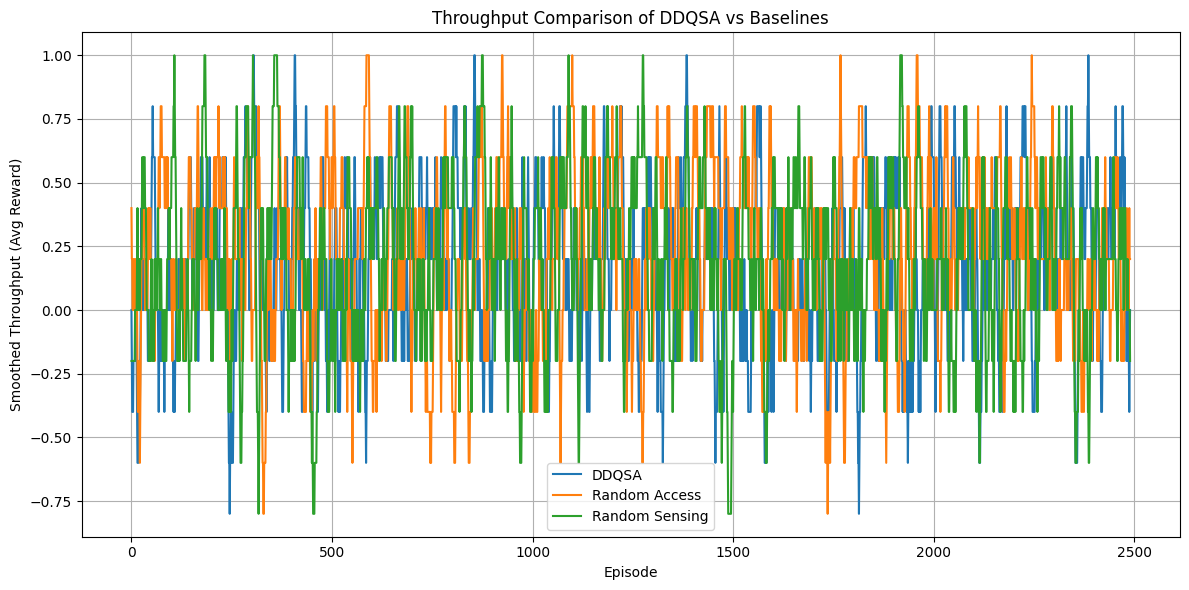

In [48]:
compare_and_plot()